In [857]:

from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn import model_selection
from arch import arch_model
from sklearn.linear_model import LinearRegression
from prophet import Prophet

In [858]:
df = pd.read_csv("data/ghana_gdp.csv",  index_col=['year'], parse_dates=['year']) # считываем датасет
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


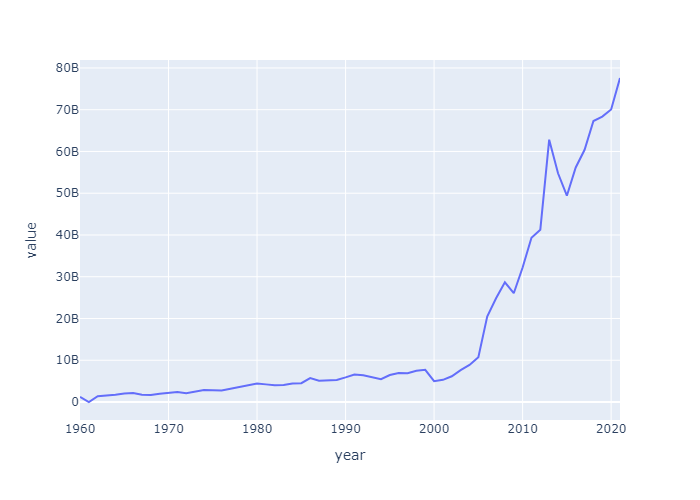

In [859]:
fig = px.line(df)
fig.update_layout(showlegend=False)
fig.show('png')

In [860]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [861]:
df.columns

Index(['GDP (current US$)'], dtype='object')

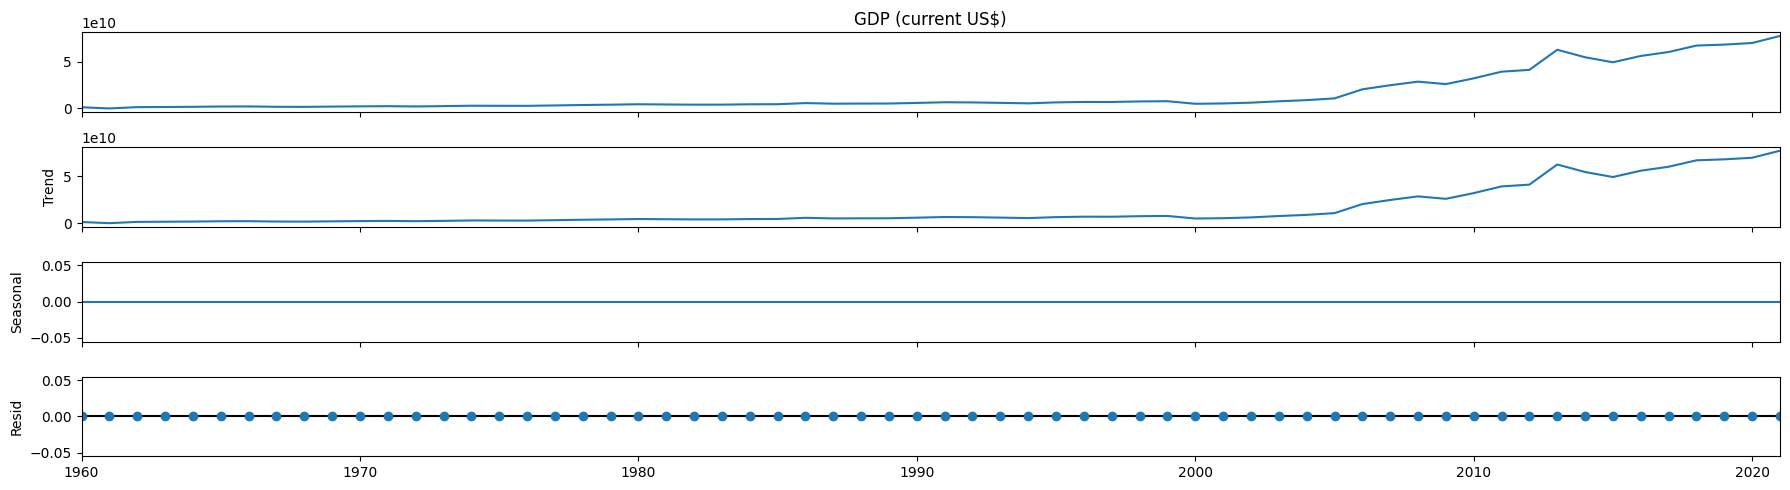

In [862]:
decomposition = seasonal_decompose(df['GDP (current US$)'])
fig = decomposition.plot()
fig.show()

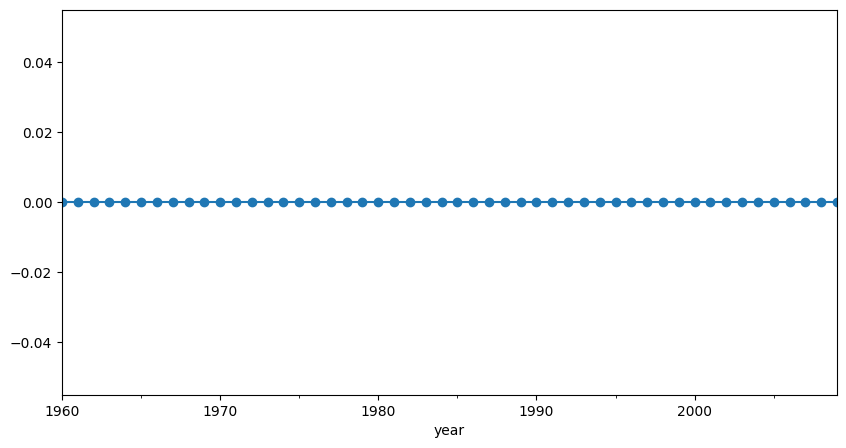

In [863]:
plt.rcParams["figure.figsize"] = 10, 5
decomposition.seasonal[:50].plot(marker="o")
plt.show()

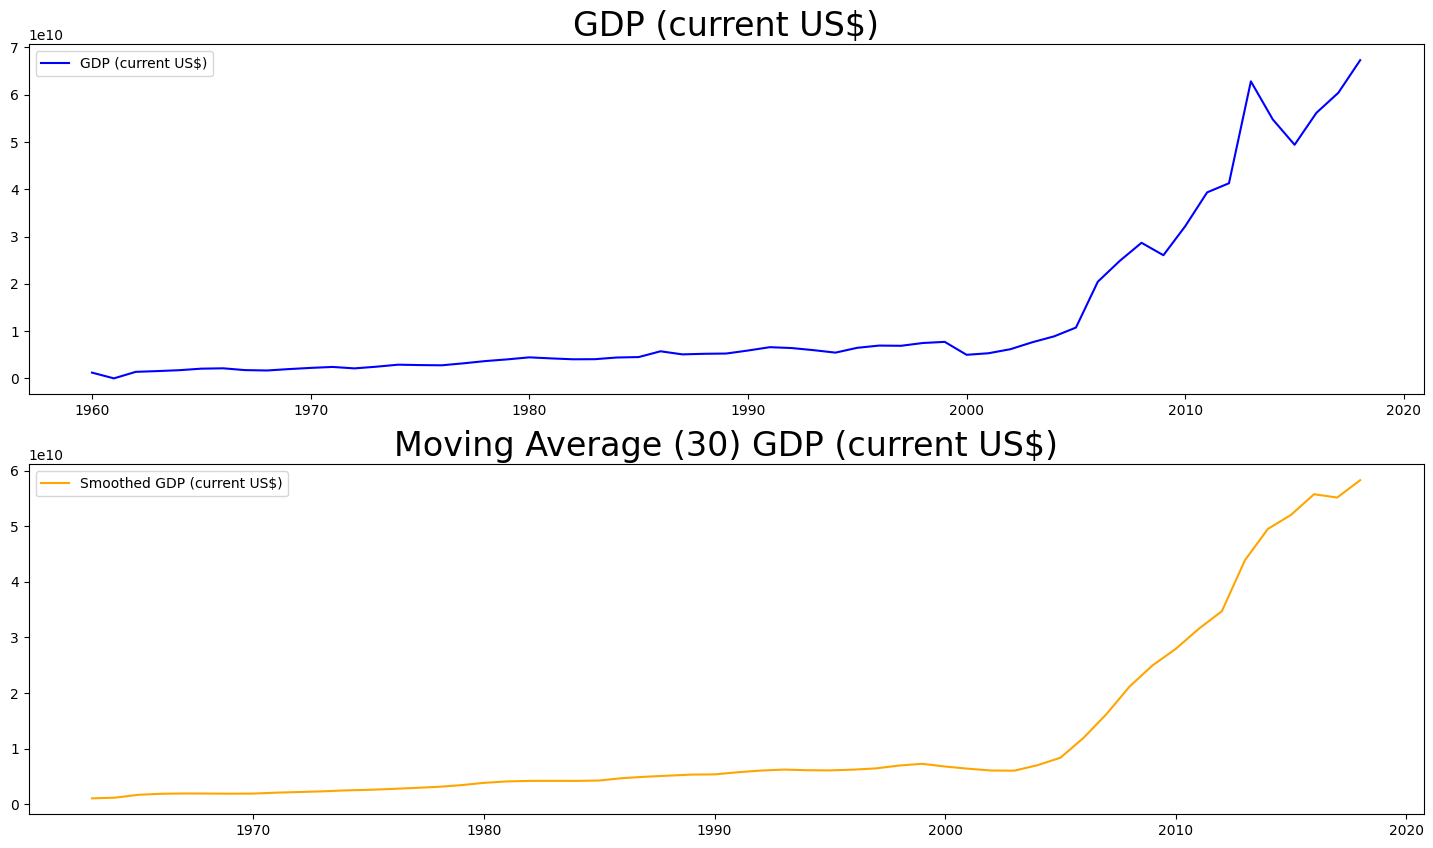

In [864]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 1)

# Окно в месяц (Window = 30)
ax[0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[0].set_title("GDP (current US$)", size=24)
ax[0].legend()

ax[1].plot(
    train_df['GDP (current US$)'].rolling(window=4).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[1].set_title("Moving Average (30) GDP (current US$)", size=24)
ax[1].legend()

plt.show()

Мы избавили ряд от выбросов и лишнего шума. Присутствует тренд, сезонности нет.

In [865]:
adfuller(train_df["GDP (current US$)"])

(0.6529066974885364,
 0.9888496277665572,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [866]:
train_df1 = train_df["GDP (current US$)"].diff().dropna()
adfuller(train_df1)

(-1.6702483038320854,
 0.446502932971385,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [867]:
train_df2 = train_df1.diff().dropna()
adfuller(train_df2)

(-2.6408690561284884,
 0.08484116917837692,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [868]:
train_df3 = train_df2.diff().dropna()
adfuller(train_df3)

(-4.779623784828542,
 5.9483276402246766e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.481155659526)

In [869]:
test1 = adfuller(train_df3)
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -4.779623784828542
p-value:  5.9483276402246766e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


После троекратного взятия разностей ряд стал стационарным. Значит может строить графики полной и частичной автокорреляции дял определения параметров модели.

In [870]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=20)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

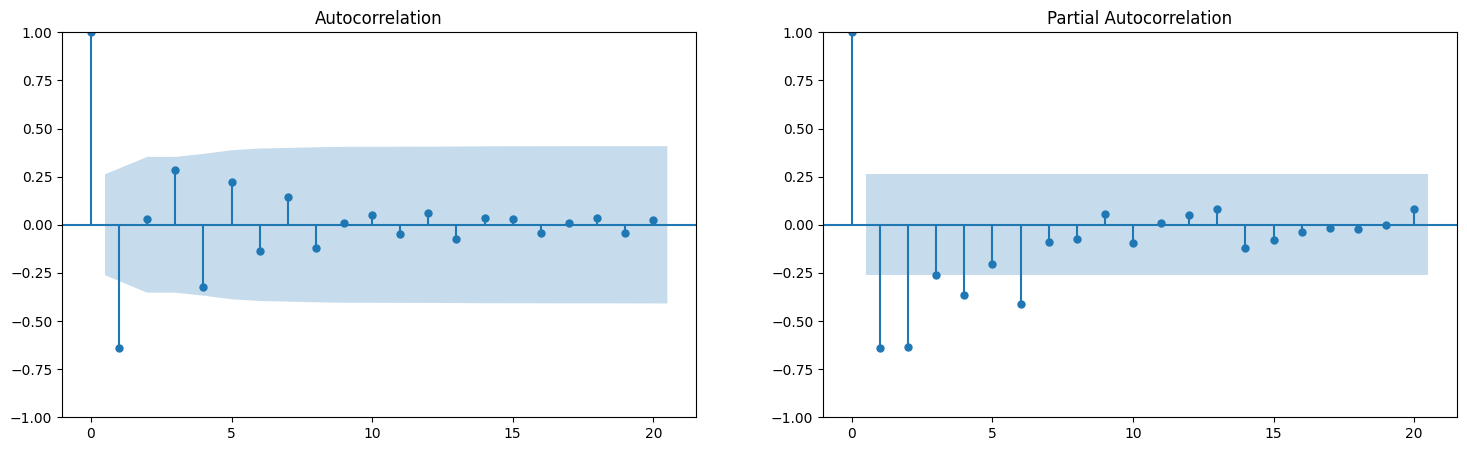

In [871]:
plot_acf_pacf(train_df3)

q=4, p=2

In [872]:
arima_model = ARIMA(train_df, order=(2, 3, 4))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 4)   Log Likelihood               -1319.397
Date:                Sat, 24 Aug 2024   AIC                           2652.795
Time:                        18:42:44   BIC                           2666.972
Sample:                    01-01-1960   HQIC                          2658.291
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7034      0.392     -4.348      0.000      -2.471      -0.936
ar.L2         -0.8815      0.349     -2.525      0.012      -1.566      -0.197
ma.L1         -0.0113      0.570     -0.020      0.984      -1.128       1.106
ma.L2         -1.6326      0.366     -4.466      0.000      -2.349      -0.916
ma.L3         -0.0202      0.781     -0.026      0.979      -1.551       1.510
ma.L4          0.7337      0.510      1.439      0.150      -0.266       1.733
sigma2      2.868e+19   1.49e-20   1.93e+39      0.000    2.87e+19    2.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                92.04
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              94.08   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.57e+55. Standard errors may be unstable.
"""

In [873]:
model = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=2,
    max_q=6,
    start_D=0,
    start_P=0,
    start_Q=0,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True
)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.09 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.07 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.09 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.891 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 24 Aug 2024   AIC                           2659.231
Time:                        18:42:45   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

In [874]:
arima_model = ARIMA(train_df, order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 24 Aug 2024   AIC                           2659.231
Time:                        18:42:45   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Вот здесь вообщен ничего не понятно. По коррелограмме q=4, по автоподбору показывает 1... Так и метрика AIC немного но ниже на параметре 4. Но поверим автоподбору параметров...

In [875]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

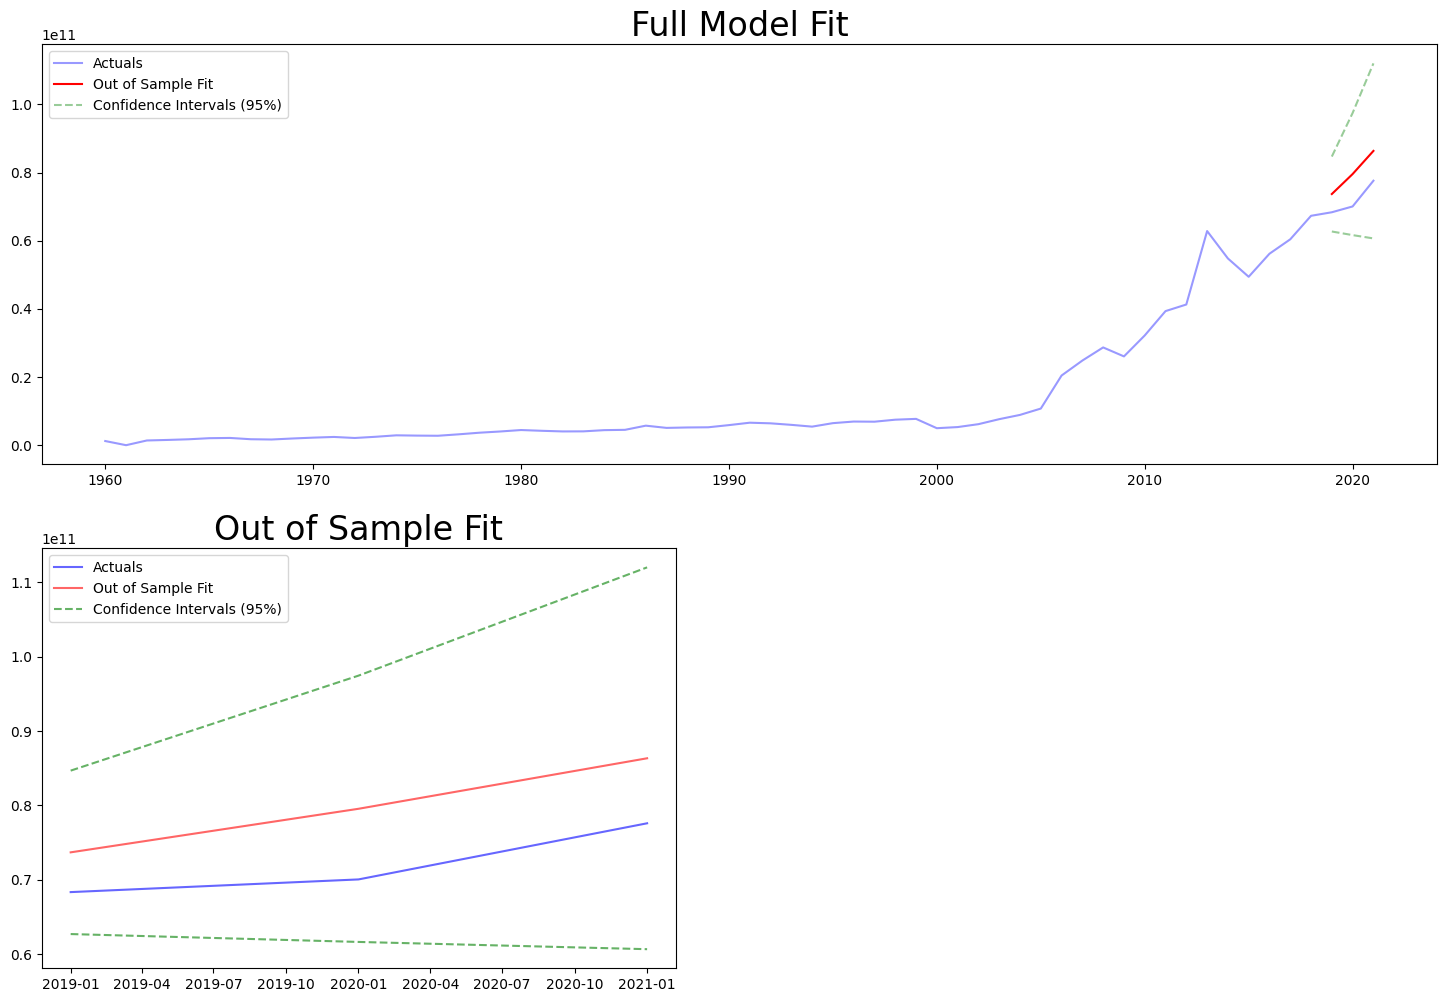

In [876]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Была выбрана ARIMA потому что начальный ряд был нестационарен и нет сезонной составляющей. Все результаты находятся внутри доверительного интервала 95%. Что вроде неплохо. Модель неплохо предсказала значения, не уловила перегиба, но он и небольшой, предсказанные значения получились близкими к реальным.

### Интерполяция

In [877]:
df.isna().sum()

GDP (current US$)    0
dtype: int64

Пропущенных значений нет.

In [878]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [879]:
df.isna().sum()

GDP (current US$)    1
dtype: int64

Оказалось что не было явных пропущенных значений, зато было значение равное 0.

In [880]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

In [881]:
df.isna().sum()

GDP (current US$)    0
dtype: int64

Благодаря интерполяции пропущенное значение заполнено.

In [882]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [883]:
adfuller(train_df["GDP (current US$)"].diff().dropna())

(-1.825565224643601,
 0.36784515276563373,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [884]:
adfuller(train_df["GDP (current US$)"].diff().diff().dropna())

(-2.6346347460078436,
 0.08604813722197652,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [885]:
adfuller(train_df["GDP (current US$)"].diff().diff().diff().dropna())

(-4.82560368730402,
 4.8573180767999755e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.481155659526)

Теперь ряд стационарен.

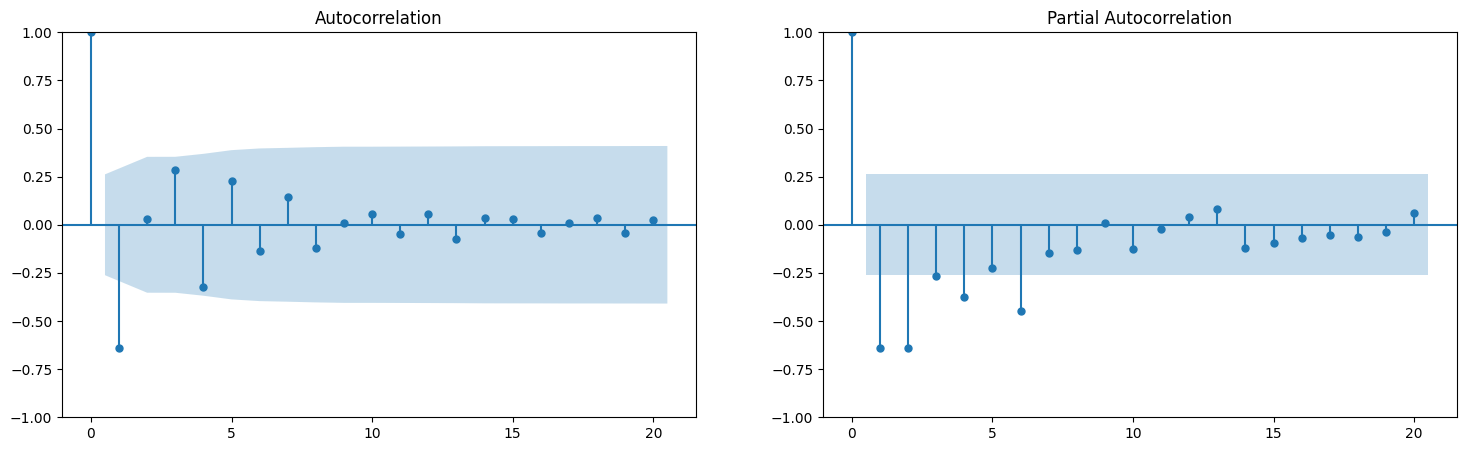

In [886]:
plot_acf_pacf(train_df["GDP (current US$)"].diff().diff().diff().dropna())

q=4, p=2

In [887]:
arima_model = ARIMA(train_df, order=(2, 3, 4))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 4)   Log Likelihood               -1319.435
Date:                Sat, 24 Aug 2024   AIC                           2652.870
Time:                        18:42:47   BIC                           2667.048
Sample:                    01-01-1960   HQIC                          2658.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6953      0.354     -4.784      0.000      -2.390      -1.001
ar.L2         -0.8759      0.302     -2.897      0.004      -1.469      -0.283
ma.L1         -0.0237      0.545     -0.043      0.965      -1.093       1.045
ma.L2         -1.6203      0.369     -4.392      0.000      -2.343      -0.897
ma.L3         -0.0065      0.667     -0.010      0.992      -1.314       1.301
ma.L4          0.7198      0.437      1.647      0.100      -0.137       1.576
sigma2      2.883e+19   2.72e-20   1.06e+39      0.000    2.88e+19    2.88e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                93.97
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             404.80   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+55. Standard errors may be unstable.
"""

In [888]:
model = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=2,
    max_q=6,
    start_D=0,
    start_P=0,
    start_Q=0,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True
)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.10 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.58 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.09 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.08 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.09 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.384 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sat, 24 Aug 2024   AIC                           2659.226
Time:                        18:42:48   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.91e+55. Standard errors may be unstable.
"""

Такая же ситуация как и выше по поводу q. Что интересно - после интерполяции модель с параметром q=4 показала чуточку худшие результаты, а с q=1 чуточку лучшие.

### Валидация

In [889]:
tscv = model_selection.TimeSeriesSplit(n_splits=3, test_size=7)

In [890]:
train_test_groups = tscv.split(df['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


### Волатильность

In [891]:
df['GDP (current US$) vol'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df['GDP (current US$) vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP (current US$) vol, dtype: float64

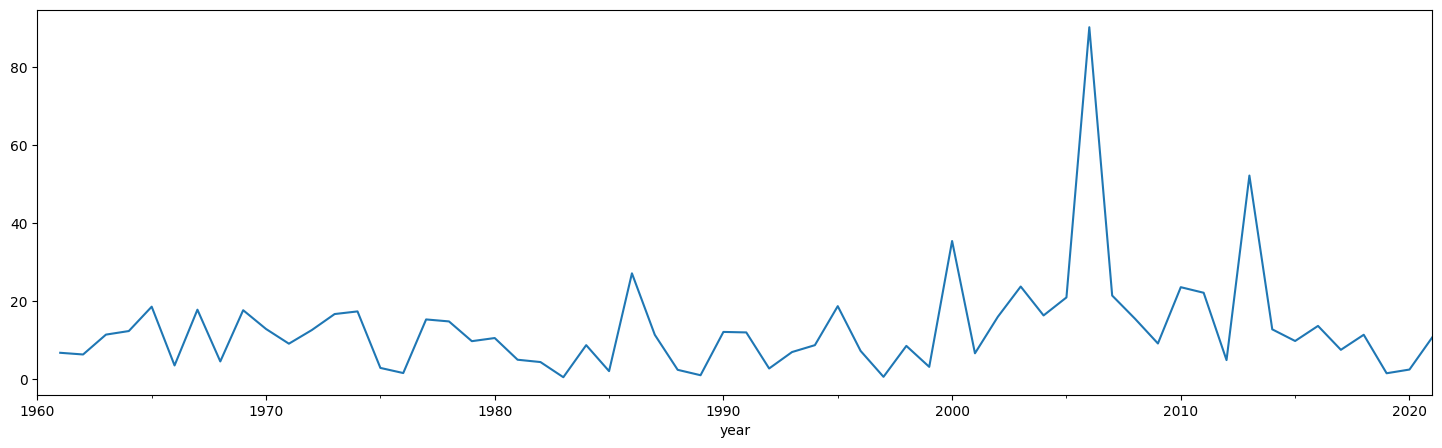

In [892]:
df['GDP (current US$) vol'].plot()
plt.show()

In [893]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

In [894]:
adfuller(train_df["GDP (current US$) vol"][1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд стационарен.

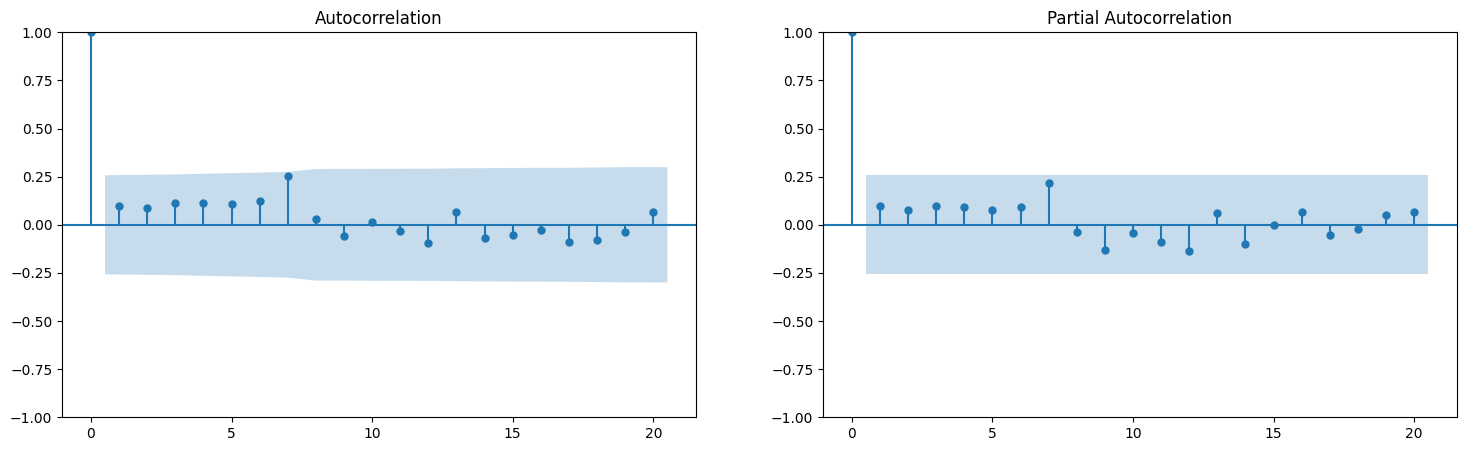

In [895]:
plot_acf_pacf(train_df["GDP (current US$) vol"].dropna())

q=7, p=7

In [896]:
garch_df = pd.DataFrame(df["GDP (current US$) vol"].loc[df.index])
garch_df.loc[train_df.index, "GDP (current US$) vol"] = train_df["GDP (current US$) vol"].dropna()

In [897]:
model = arch_model(garch_df["GDP (current US$) vol"].dropna(), p=7, q=7, vol='GARCH')

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [898]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$) vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -214.008
Distribution:                     Normal   AIC:                           460.016
Method:               Maximum Likelihood   BIC:                           492.983
                                           No. Observations:                   58
Date:                   Sat, Aug 24 2024   Df Residuals:                       57
Time:                           18:42:49   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

In [899]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

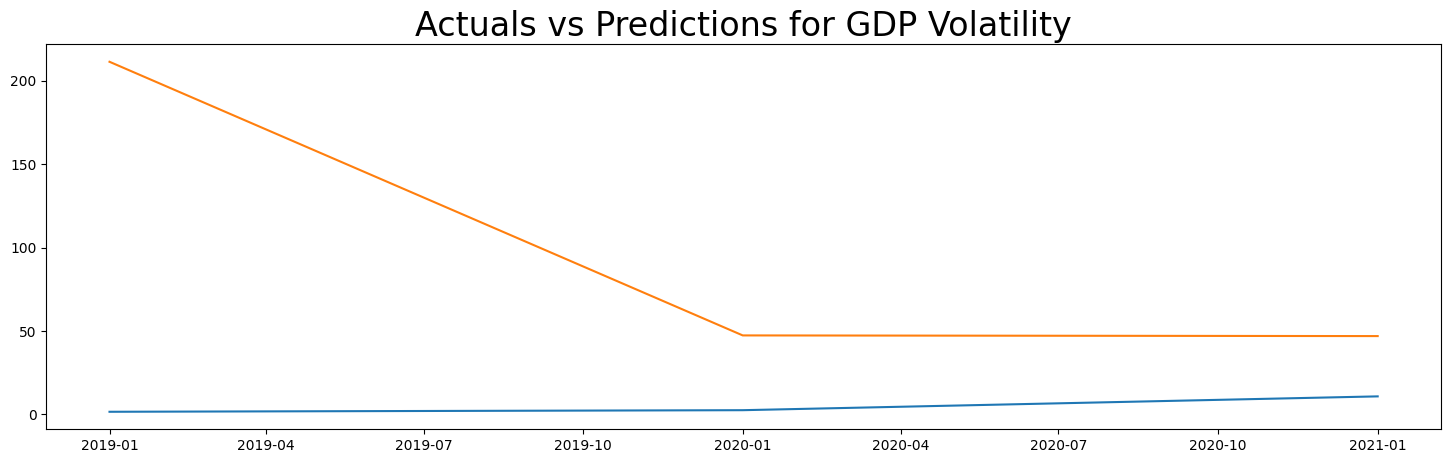

In [900]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP (current US$) vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

### Линейная регрессия

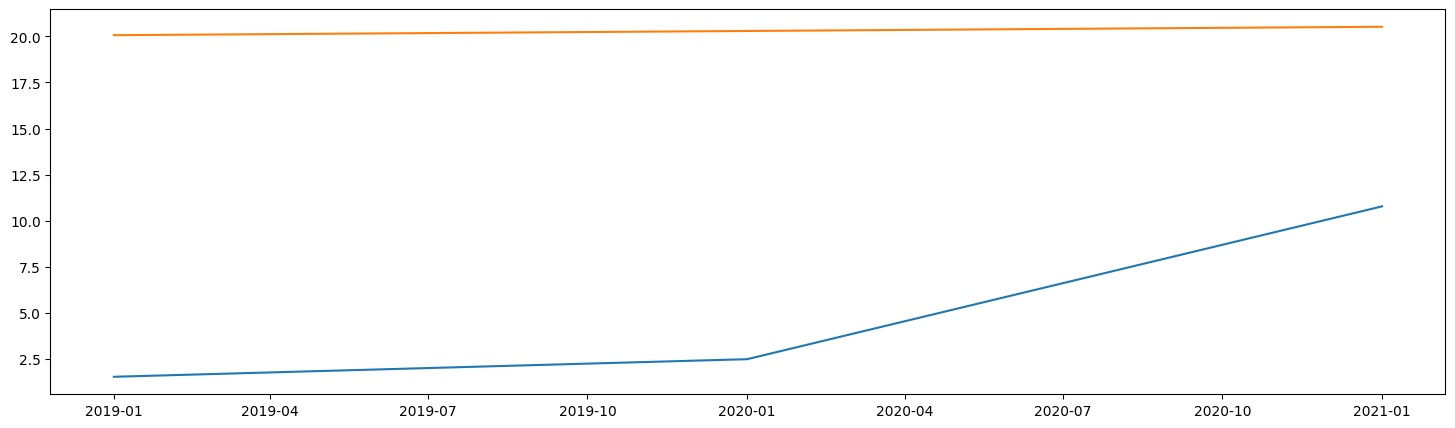

In [901]:
X_train = pd.DataFrame(range(df["GDP (current US$) vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["GDP (current US$) vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP (current US$) vol"].fillna(0)
y_test = test_df["GDP (current US$) vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Даже не знаю что написать. По-моему линейная регрессия показала лучший результат чем GARCH, зависимости не уловила, но значения намного ближе к реальности.

In [914]:
train_df['ds'] = train_df.index
train_df['y'] = train_df['GDP (current US$)']

In [916]:
model = Prophet()
model.fit(train_df)

18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing


In [917]:
future_df = model.make_future_dataframe(periods=1095)

future_df.tail()

,ds
1149,2020-12-27
1150,2020-12-28
1151,2020-12-29
1152,2020-12-30
1153,2020-12-31


In [918]:
forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1149,2020-12-27,3.592400e+10,2.105176e+10,4.961441e+10
1150,2020-12-28,3.533023e+10,2.102958e+10,4.896573e+10
1151,2020-12-29,3.537115e+10,2.157032e+10,4.932037e+10
1152,2020-12-30,3.605712e+10,2.260734e+10,4.988086e+10
1153,2020-12-31,3.738186e+10,2.210259e+10,5.155046e+10


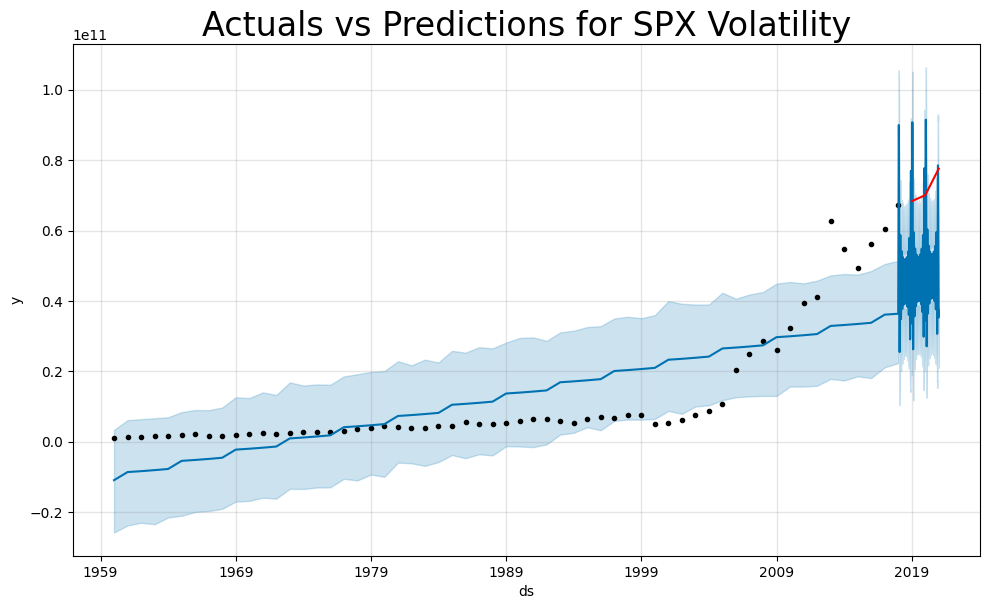

In [919]:
plt.rcParams["figure.figsize"] = 18, 5

model.plot(forecast_df)
plt.plot(test_df['GDP (current US$)'], color="red", linestyle="-")

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

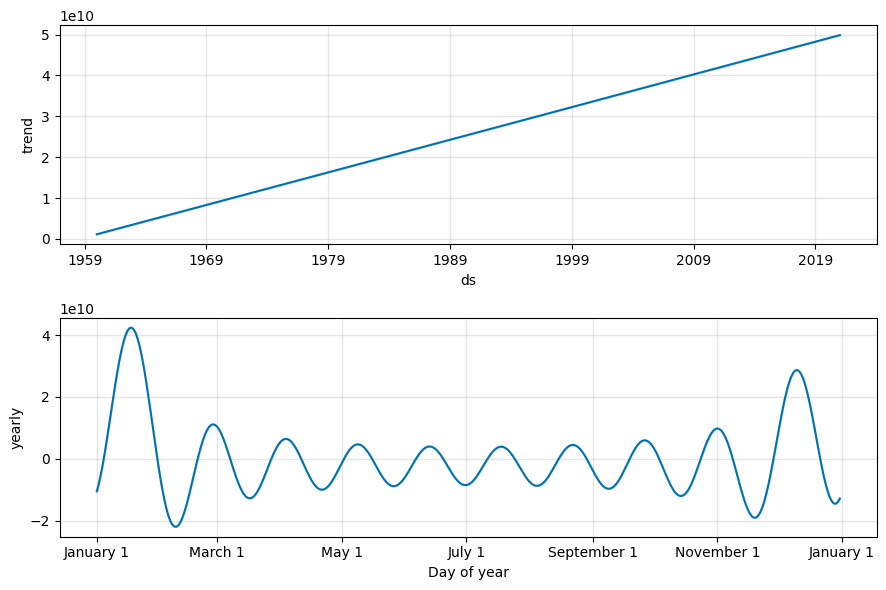

In [920]:
fig = model.plot_components(forecast_df)

Как-то не очень... ARIMA  справилась лучше.